In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999 # to display all rows
pd.options.display.max_columns = 999 # to display all columns

In [3]:
miles_df = pd.read_csv("Data/Mileage.csv", engine = "python")

In [4]:
miles_df

,Monday,Mileage,Notes
0,8/19/2019,293.8,NaN
1,8/26/2019,955.0,Milwaukee
2,9/2/2019,167.8,NaN
3,9/9/2019,411.4,La Crosse
4,9/16/2019,958.9,Chicago
5,9/23/2019,87.0,NaN
6,9/30/2019,130.1,NaN
7,10/7/2019,1007.5,Chicago
8,10/14/2019,88.3,NaN
9,10/21/2019,118.7,NaN


In [5]:
miles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 3 columns):
Monday     70 non-null object
Mileage    69 non-null float64
Notes      12 non-null object
dtypes: float64(1), object(2)
memory usage: 1.8+ KB


### Idenity any weeks where mileage was not recorded

In [6]:
miles_df[miles_df["Mileage"].isnull()]

,Monday,Mileage,Notes
29,3/9/2020,NaN,Car battery died


### How should the missing value be imputed?

In [7]:
miles_df.describe()

,Mileage
count,69.000000
mean,169.723188
std,244.174248
min,0.000000
25%,44.700000
50%,87.000000
75%,150.400000
max,1007.500000


mean? median? or perhaps something more specific?

In [8]:
miles_df.loc[:,"Notes"].unique()

array([nan, 'Milwaukee', 'La Crosse', 'Chicago', 'Car battery died',
       'Milwaukee; Coronavirus begins, 3/11 NBA postponed season',
       'Redwood Falls and Mankato', 'Winona', 'Mankato'], dtype=object)

In [9]:
# identify when travel occurred; notes only exist for travels outside metro area
miles_df["travel_ind"] = np.where(miles_df['Notes'].notnull(), 1, 0)

# car battery died and no travel occurred
miles_df["travel_ind"] = np.where(miles_df['Notes'].str.lower().str.contains("car battery", na = False), 
                                   0, miles_df["travel_ind"])

I travel to Chicago a lot.

In [10]:
miles_df.groupby(["Notes"]).agg({"travel_ind":"count"}).sort_values("travel_ind", ascending = False)

,travel_ind
Notes,
Chicago,5
Car battery died,1
La Crosse,1
Mankato,1
Milwaukee,1
"Milwaukee; Coronavirus begins, 3/11 NBA postponed season",1
Redwood Falls and Mankato,1
Winona,1


Group by `travel_ind` and get average mileage.

In [11]:
grouped_df = miles_df.groupby(["travel_ind"]).agg({"Mileage":["count","mean","median"]})
grouped_df

Mileage                   
             count        mean median
travel_ind                           
0               58   87.389655   73.8
1               11  603.845455  411.4

Impute missing values for mileage with mean of weeks where I didn't travel.

In [12]:
# exclude first level of multi-indexed columns resulting from the groupby
grouped_df.columns = grouped_df.columns.droplevel(0)

# get the number to impute the null value in Mileage
non_travel_mean_mileage = grouped_df.loc[0, "mean"].round(1)
non_travel_mean_mileage

87.4

### Impute missing mileage value

In [15]:
miles_df["Mileage"] = np.where(miles_df["Mileage"].isnull(), non_travel_mean_mileage, miles_df["Mileage"]).round(1)

miles_df.loc[miles_df["Monday"] == "3/9/2020"]

,Monday,Mileage,Notes,travel_ind
29,3/9/2020,87.4,Car battery died,0


Mileage field is ready to be used.

### Create Destination Indicators

In [16]:
miles_df["Milwaukee"] = np.where(miles_df['Notes'].str.lower().str.contains("milwaukee", na = False), 1, 0)
miles_df["Chicago"] = np.where(miles_df['Notes'].str.lower().str.contains("chicago", na = False), 1, 0)

### Identifying when Coronovirus started

In [17]:
miles_df.loc[miles_df['Notes'].str.lower().str.contains("coronavirus", na = False)]

,Monday,Mileage,Notes,travel_ind,Milwaukee,Chicago
30,3/16/2020,843.3,"Milwaukee; Coronavirus begins, 3/11 NBA postpo...",1,1,0


### Chow Breakpoint Test

test whether one regression or two or more regressions best characterise the data. 

test is capable of detecting "structural breaks" within time-series

In [ ]:
# pip install chowtest

In [18]:
from chow_test import chowtest

In [19]:
chowtest(y = miles_df[["Mileage"]],
         X = miles_df[["travel_ind"]],
         last_index_in_model_1 = "29",
         first_index_in_model_2 = "30",
         significance_level = 0.05)

****************************************************************************************************
Reject the null hypothesis of equality of regression coefficients in the 2 periods.
****************************************************************************************************
Chow Statistic: 12.752858942889294 p value: 0.0
****************************************************************************************************


(12.752858942889294, 1.1116191744875437e-08)

In [20]:
chowtest(y = miles_df[["Mileage"]],
         X = miles_df[["travel_ind","Milwaukee","Chicago"]],
         last_index_in_model_1 = "29",
         first_index_in_model_2 = "30",
         significance_level = 0.05)

****************************************************************************************************
Reject the null hypothesis of equality of regression coefficients in the 2 periods.
****************************************************************************************************
Chow Statistic: 8.786592900213678 p value: 0.0
****************************************************************************************************


(8.786592900213678, 2.411714624450667e-06)

### Create Covid Indicator

In [22]:
# change Monday to date column
miles_df["Monday"] = pd.to_datetime(miles_df["Monday"])

# create indicator for Coronavirus period vs non-Coronavirus period
miles_df["covid_ind"] = np.where(miles_df['Monday'] >= "3/16/2020", 1, 0)

miles_df.groupby(["covid_ind"]).agg({"Mileage":["count","mean","median"]})

Mileage                    
            count        mean  median
covid_ind                            
0              30  229.366667  125.05
1              40  122.932500   48.20

### OLS Regression

In [25]:
import statsmodels.api as sm

In [26]:
miles_x = miles_df[["travel_ind","covid_ind","Milwaukee","Chicago"]]
miles_y = miles_df[["Mileage"]]

In [27]:
# statsmodels function doesn't include a constant term, so, add a constant term to the equation.
X = sm.add_constant(miles_x)
model = sm.OLS(miles_y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Mileage   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     70.22
Date:                Tue, 22 Dec 2020   Prob (F-statistic):           6.95e-23
Time:                        14:10:42   Log-Likelihood:                -424.71
No. Observations:                  70   AIC:                             859.4
Df Residuals:                      65   BIC:                             870.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        151.7746     20.375      7.449      0.000     111.083     192.466
travel_ind   241.0845     56.207      4.289      0.000     128.832     353.337
covid_ind   -115.1122     26.285     -4.379      0.000    -167.608     -62.617
Milwaukee    563.8470     94.066      5.994      0.000     375.983     751.710
Chicago      399.7882     72.792      5.492      0.000     254.412     545.164
==============================================================================
Omnibus:                       17.726   Durbin-Watson:                   1.386
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.613
Skew:                           0.735   Prob(JB):                     9.20e-10
Kurtosis:                       6.480   Cond. No.                         10.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
miles_x = miles_df[["travel_ind","covid_ind"]]
miles_y = miles_df[["Mileage"]]

In [29]:
# statsmodels function doesn't include a constant term, so, add a constant term to the equation.
X = sm.add_constant(miles_x)
model = sm.OLS(miles_y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Mileage   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     70.63
Date:                Tue, 22 Dec 2020   Prob (F-statistic):           3.16e-17
Time:                        14:11:52   Log-Likelihood:                -443.53
No. Observations:                  70   AIC:                             893.1
Df Residuals:                      67   BIC:                             899.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        159.1873     26.220      6.071      0.000     106.853     211.522
travel_ind   526.3451     45.933     11.459      0.000     434.662     618.028
covid_ind   -128.3652     33.780     -3.800      0.000    -195.790     -60.940
==============================================================================
Omnibus:                        8.037   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.861
Skew:                           0.536   Prob(JB):                       0.0119
Kurtosis:                       4.374   Cond. No.                         3.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

log Mileage

In [34]:
# can't take log of 0, so offset Mileage by 1 mile
miles_df["Mileage_log"] = np.log(miles_df["Mileage"]+1)

In [35]:
miles_x = miles_df[["travel_ind","covid_ind","Milwaukee","Chicago"]]
miles_y = miles_df[["Mileage_log"]]

In [36]:
# statsmodels function doesn't include a constant term, so, add a constant term to the equation.
X = sm.add_constant(miles_x)
model = sm.OLS(miles_y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Mileage_log   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     11.74
Date:                Tue, 22 Dec 2020   Prob (F-statistic):           3.09e-07
Time:                        14:16:24   Log-Likelihood:                -122.03
No. Observations:                  70   AIC:                             254.1
Df Residuals:                      65   BIC:                             265.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4423      0.270     16.460      0.000       3.903       4.981
travel_ind     2.2785      0.745      3.060      0.003       0.792       3.765
covid_ind     -1.3828      0.348     -3.972      0.000      -2.078      -0.687
Milwaukee      0.7712      1.246      0.619      0.538      -1.717       3.260
Chicago        0.6046      0.964      0.627      0.533      -1.321       2.530
==============================================================================
Omnibus:                       14.282   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.618
Skew:                          -1.070   Prob(JB):                     0.000406
Kurtosis:                       3.879   Cond. No.                         10.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
miles_x = miles_df[["travel_ind","covid_ind"]]
miles_y = miles_df[["Mileage_log"]]

In [38]:
# statsmodels function doesn't include a constant term, so, add a constant term to the equation.
X = sm.add_constant(miles_x)
model = sm.OLS(miles_y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Mileage_log   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     23.72
Date:                Tue, 22 Dec 2020   Prob (F-statistic):           1.62e-08
Time:                        14:16:38   Log-Likelihood:                -122.32
No. Observations:                  70   AIC:                             250.6
Df Residuals:                      67   BIC:                             257.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4528      0.267     16.705      0.000       3.921       4.985
travel_ind     2.6950      0.467      5.771      0.000       1.763       3.627
covid_ind     -1.4016      0.343     -4.081      0.000      -2.087      -0.716
==============================================================================
Omnibus:                       13.726   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.811
Skew:                          -1.049   Prob(JB):                     0.000608
Kurtosis:                       3.823   Cond. No.                         3.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notes:
    
Mileage is not normally distributed, as expected. I don't regularly travel long distance. Further, driving less during the covid pandemic skews the istribution further. A non-normal distribution makes it harder to capture the pattern in weekly mileage. This is the nature of the data and what we want to explore in the first place, not statistically correct it.

DB-stat

null hypothesis that the errors are serially uncorrelated against the alternative that they follow a first order autoregressive process

In [42]:
from matplotlib import pyplot as plt

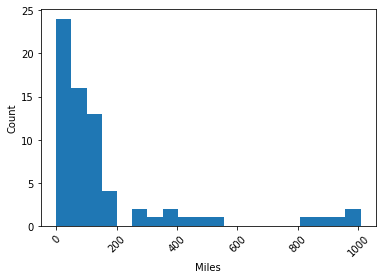

In [51]:
plt.hist(miles_df["Mileage"], density = False, bins = 20)
plt.ylabel("Count")
plt.xlabel("Miles")
plt.xticks(rotation = 45)
plt.show()

In [ ]:
plt.hist(miles_df["Mileage"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("Total At Risk")
plt.xticks(rotation = 45)

plt.subplot(1, 2, 2)
plt.hist(mmsa_df["total_at_risk_log"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("Logged Total At Risk")

plt.tight_layout()
plt.show()

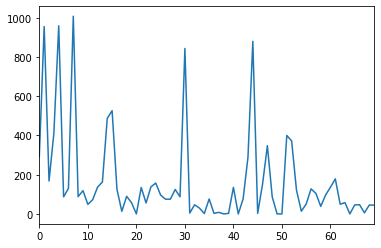

In [43]:
miles_df["Mileage"].plot()
plt.show()

In [52]:
from pandas.plotting import autocorrelation_plot

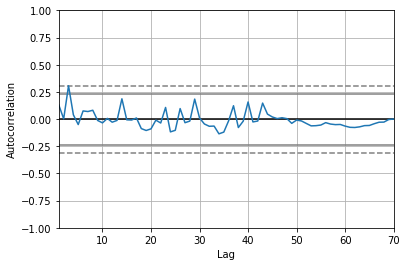

In [53]:
autocorrelation_plot(miles_df["Mileage"])
plt.show()

In [58]:
from statsmodels.tsa.arima_model import ARIMA

In [85]:
ts_model = ARIMA(miles_df["Mileage_log"], order=(3,1,0))
ts_model_fit = ts_model.fit()

In [86]:
print(ts_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Mileage_log   No. Observations:                   69
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -139.792
Method:                       css-mle   S.D. of innovations              1.825
Date:                Tue, 22 Dec 2020   AIC                            289.584
Time:                        15:47:43   BIC                            300.754
Sample:                             1   HQIC                           294.016
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0375      0.089     -0.422      0.675      -0.212       0.137
ar.L1.D.Mileage_log    -0.6797      0.114     -5.943      0.000      -0.904      -0.456
ar.L2.D.Mileage_

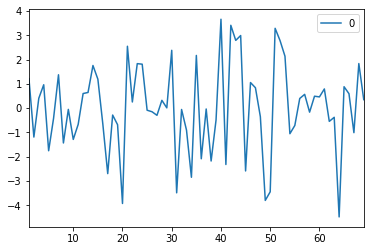

In [87]:
# line plot fo residuals
residuals = pd.DataFrame(ts_model_fit.resid)
residuals.plot()
plt.show()

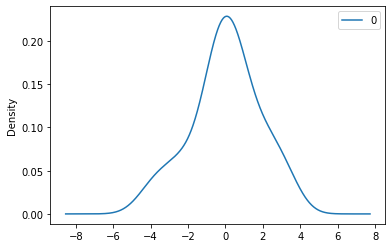

In [88]:
residuals.plot(kind = "kde")
plt.show()

In [89]:
print(residuals.describe())

               0
count  69.000000
mean    0.005217
std     1.841638
min    -4.475151
25%    -0.904485
50%    -0.034308
75%     1.053869
max     3.658634


In [41]:
miles_df

,Monday,Mileage,Notes,travel_ind,Milwaukee,Chicago,covid_ind,Mileage_log
0,2019-08-19,293.8,NaN,0,0,0,0,5.686297
1,2019-08-26,955.0,Milwaukee,1,1,0,0,6.862758
2,2019-09-02,167.8,NaN,0,0,0,0,5.128715
3,2019-09-09,411.4,La Crosse,1,0,0,0,6.021994
4,2019-09-16,958.9,Chicago,1,0,1,0,6.866829
5,2019-09-23,87.0,NaN,0,0,0,0,4.477337
6,2019-09-30,130.1,NaN,0,0,0,0,4.875960
7,2019-10-07,1007.5,Chicago,1,0,1,0,6.916219
8,2019-10-14,88.3,NaN,0,0,0,0,4.492001
9,2019-10-21,118.7,NaN,0,0,0,0,4.784989


In [ ]:
1) impute missing value
2) create travel indicator
3) chow breakpoint test
4) covid indicator
5) ols model with travel indicator and covid indicator
6) arima model
7) arima model with travel indicator and covid indicator